# ShopUp team 
In this notebook our team reveal two different approaches for creating recommender system in Retail (ecommerce) during the Summer Data Science School using:
- Deep Collaborative Filtering
- Session Based Recommendations with RNN
You can find more information about the case the other approaches and all other into at our article at [Shopup](https://shopup.me) and the repo for Learning Item Embedding which we call product2Vec.
https://shopup.me/recommenders_systems/


In [0]:
from fastai.collab import *
from fastai.tabular import *
from fastai.text import *

import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/"
base_dir = root_dir + 'summer_school/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1. Data Prep

### Load data

In [0]:
sorted_df = pd.read_csv(base_dir +'/events.csv')
sorted_df["date"] = pd.DatetimeIndex(sorted_df["timestamp"]).date
sorted_df.head()

,timestamp,visitorid,event,itemid,transactionid,date
0,1433221332117,257597,view,355908,NaN,1970-01-01
1,1433224214164,992329,view,248676,NaN,1970-01-01
2,1433221999827,111016,view,318965,NaN,1970-01-01
3,1433221955914,483717,view,253185,NaN,1970-01-01
4,1433221337106,951259,view,367447,NaN,1970-01-01


In [0]:
# adding ratings if they browse is one if they add to card is 3 and 5 for transaction

sorted_df["rating1"] = np.where(sorted_df.event == "view",1,3)
sorted_df["rating2"] = np.where((sorted_df.event == "transaction") & (sorted_df["rating1"] == 3),2,0)

sorted_df['rating'] = sorted_df["rating1"] + sorted_df["rating2"]
sorted_df.head()

,timestamp,visitorid,event,itemid,transactionid,date,rating1,rating2,rating
0,1433221332117,257597,view,355908,NaN,1970-01-01,1,0,1
1,1433224214164,992329,view,248676,NaN,1970-01-01,1,0,1
2,1433221999827,111016,view,318965,NaN,1970-01-01,1,0,1
3,1433221955914,483717,view,253185,NaN,1970-01-01,1,0,1
4,1433221337106,951259,view,367447,NaN,1970-01-01,1,0,1


## Deep collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
ratings = sorted_df[["visitorid", 'itemid', "rating", 'timestamp']].copy()
ratings.head()

,visitorid,itemid,rating,timestamp
0,257597,355908,1,1433221332117
1,992329,248676,1,1433224214164
2,111016,318965,1,1433221999827
3,483717,253185,1,1433221955914
4,951259,367447,1,1433221337106


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)
data

TabularDataBunch;

Train: LabelList (2204881 items)
x: CollabList
visitorid 257597; itemid 355908; ,visitorid 111016; itemid 318965; ,visitorid 483717; itemid 253185; ,visitorid 951259; itemid 367447; ,visitorid 810725; itemid 443030; 
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: .;

Valid: LabelList (551220 items)
x: CollabList
visitorid 50734; itemid 4442; ,visitorid 355903; itemid 269631; ,visitorid 1066758; itemid 221329; ,visitorid 1049477; itemid 23683; ,visitorid #na#; itemid 6552; 
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: .;

Test: None

In [0]:
y_range = [0,5.5]
learn = collab_learner(data, n_factors=50, y_range=y_range)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


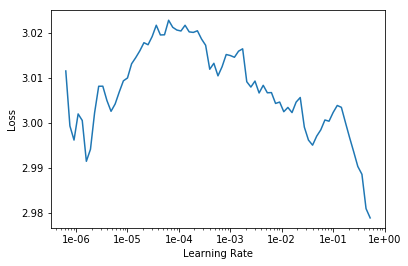

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,1.059326,1.015739,18:38


In [0]:
# save the model

learn.save(base_dir +'/dotcat')


## Session base recommendation with RNNs

In [3]:
# need to prepare the data in the format shown below
final_text= pd.read_csv(base_dir +'/final_text_no_bracket.csv')
final_text.head()

,visitorid,new
0,0,"285930, 357564, 67045, 285930, 357564, 67045, ..."
1,1,72028
2,2,"325215, 325215, 259884, 216305, 342816, 342816..."
3,3,385090
4,4,177677


In [0]:
from fastai.text import *
data_lm = (TextList.from_df(final_text, cols=['visitorid', 'new'])
                   .split_by_rand_pct()
                   .label_for_lm()
                   .databunch())

In [0]:
data_lm.save(base_dir +'/data_lm.pkl')
#data_lm.load(base_dir +'/data_lm.pkl')

In [5]:
data_lm.vocab.itos[:11]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',',
 '4']

In [6]:
data_lm.show_batch()

idx,text
0,"325215 , 325215 , 325215 , 259884 , 216305 , 342816 , 342816 , 216305 , 325215 , 325215 , 325215 , 259884 , 216305 , 342816 , 342816 , 216305 , 325215 , 325215 , 325215 , 259884 , 216305 , 342816 , 342816 , 216305 , 325215 , 325215 , 325215 , 259884 , 216305 , 342816 , 342816 , 216305 , 325215 , 325215 , 325215 ,"
1,"xxunk xxunk xxbos xxunk xxunk , 450135 , xxunk , 450135 xxbos xxunk 137126 , 137126 , 348134 , 348134 , 137126 , 137126 , 348134 , 348134 , 137126 , 137126 , 348134 , 348134 , 137126 , 137126 , 348134 , 348134 xxbos 1590 66752 xxbos xxunk 43267 xxbos xxunk 230223 , 261288 , 92493 , 92493 , 230223 , 261288 , 92493 , 92493 , 230223 ,"
2,"210848 , 165696 , 93761 , 293512 , 395407 , 270798 , 270798 , 178991 , 80661 , 270798 , 80661 , 380440 , 380440 , 270798 , 80661 , 125819 , 441974 , 240496 , 433461 , 380440 , 270798 , 80661 , 380440 , 284299 , 245626 , 441974 , 122534 , 20773 , 462018 , 146857 , 105962 , 440386 , 165696 , 93761 , 93761 ,"
3,"51118 , 61925 , 135883 , 293397 , 219328 , 463804 , 195666 , 7349 , 195666 , 195666 , 7349 , 135883 , 61925 , 72077 , 334601 , 126929 , 217352 , 225028 , 129796 , 449567 , 27719 , 58679 , 247343 , 354585 , 337671 , 114250 , 252596 , 412409 , 422829 , 310764 , 8185 , 83707 , 251394 , 325310 , 335661 ,"
4,", 251394 , 325310 , 335661 , 335661 , 297765 , 382054 , 42002 , 426277 , xxwrep 4 29863 , 451726 , 114250 , 412409 , 282419 , 437362 , 32259 , 337671 , 29167 , 29167 , 10572 , 445258 , 189197 , 97893 , 242493 , 83937 , 109499 , 223481 , 92695 , 230234 , 147493 , 67125 , 147493 , 83937 , 444707 , 466657"


In [0]:
bs=48
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


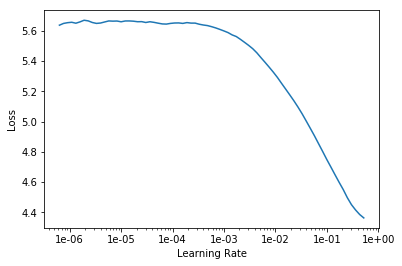

In [9]:
learn.recorder.plot(skip_end=15)

In [11]:
learn.fit_one_cycle(2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.422576,2.205910,0.673501,00:58
1,0.376518,2.247994,0.668457,00:59


In [0]:
learn.save(base_dir +'fit_head')

In [0]:
learn.save(base_dir +'/fine_tuned')

###Let's play

In [0]:
#learn.load(base_dir +'/fine_tuned_1')

In [0]:
TEXT = "440866"
N_WORDS = 4
N_SENTENCES = 1

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS +1 , temperature=0.75) for _ in range(N_SENTENCES)))

440866 205872 xxbos 27228 293808 xxbos
